In [20]:
import os

# 禁用 JAX 的显存预分配
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
from evox import Problem, algorithms,jit_class, monitors, workflows
from evox.operators import mutation, crossover, selection
from jax import random
import jax.numpy as jnp

import sys
sys.path.append('../my_so_algorithm')  # 添加路径到系统路径


sys.path.append('/home/cyh/evox/eld_1_test')  # 添加包含my_pso.py文件的路径


In [21]:
lb=jnp.array([36, 36, 60, 80, 47, 68, 110, 135, 135, 130, 94, 94, 125, 125, 125,
                           125, 220, 220, 242, 242, 254, 254, 254, 254, 254, 254, 10, 10, 10,
                           47, 60, 60, 60, 90, 90, 90, 25, 25, 25, 242])
ub=jnp.array([114, 114, 120, 190, 97, 140, 300, 300, 300, 300, 375, 375, 500, 500,
                           500, 500, 500, 500, 550, 550, 550, 550, 550, 550, 550, 550, 150, 150,
                           150, 97, 190, 190, 190, 200, 200, 200, 110, 110, 110, 550])
Pd=10500
    
a=jnp.array([0.0069, 0.0069, 0.02028, 0.00942, 0.0114, 0.01142, 0.00357, 0.00492,
                        0.00573, 0.00605, 0.00515, 0.00569, 0.00421, 0.00752, 0.00708, 0.00708,
                        0.00313, 0.00313, 0.00313, 0.00313, 0.00298, 0.00298, 0.00284, 0.00284, 0.00277,
                        0.00277, 0.52124, 0.52124, 0.52124, 0.0114, 0.0016, 0.0016, 0.0016, 0.0001,
                        0.0001, 0.0001, 0.0161, 0.0161, 0.0161, 0.00313])
b=jnp.array([6.7300, 6.7300, 7.0700, 8.1800, 5.3500, 8.0500, 8.0300, 6.9900, 6.6000, 12.9000,
                        12.9000, 12.8000, 12.5000, 8.8400, 9.1500, 9.1500, 7.9700, 7.9500, 7.9700, 7.9700,
                         6.6300, 6.6300, 6.6600, 6.6600, 7.1000, 7.1000, 3.3300, 3.3300, 3.3300, 5.3500,
                         6.4300, 6.4300, 6.4300, 8.9500, 8.6200, 8.6200, 5.8800, 5.8800, 5.8800, 7.9700])
# c=jnp.array([0.094705, 0.094705, 0.30954, 0.36903, 0.14889, 0.22233, 0.28771, 0.39198,
#                         0.45576, 0.72282, 0.6352, 0.65469, 0.9134, 1.7604, 1.7283, 1.7283, 0.64785,
#                         0.64969, 0.64783, 0.64781, 0.78596, 0.78596, 0.79453, 0.79453, 0.80132, 0.80132,
#                         1.0551, 1.0551, 1.0551, 0.14889, 0.22292, 0.22292, 0.22292, 0.10787, 0.11658,
#                         0.11658, 0.30745, 0.30745, 0.30745, 0.64783]) * 1000
c = jnp.array([94.705, 94.705, 309.54, 369.03, 148.89, 222.33, 287.71, 391.98,
               455.76, 722.82, 635.2, 654.69, 913.4, 1760.4, 1728.3, 1728.3,
               647.85, 649.69, 647.83, 647.81, 785.96, 785.96, 794.53, 794.53,
               801.32, 801.32, 1055.1, 1055.1, 1055.1, 148.89, 222.92, 222.92,
               222.92, 107.87, 116.58, 116.58, 307.45, 307.45, 307.45, 647.83])


g=jnp.array([
                100, 100, 100, 150, 120, 100, 200, 200, 200, 200, 200, 200, 300, 300, 300, 300,
                300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 120, 120, 120, 120, 150, 150,
                150, 200, 200, 200, 80, 80, 80, 300
            ])

h=jnp.array([
                0.0840, 0.0840, 0.0840, 0.0630, 0.0770, 0.0840, 0.0420, 0.0420, 0.0420, 0.0420,
                0.0420, 0.0420, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350,
                0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0770, 0.0770, 0.0770, 0.0770,
                0.0630, 0.0630, 0.0630, 0.0420, 0.0420, 0.0420, 0.0980, 0.0980, 0.0980, 0.0350
            ])

In [22]:
import evox
from evox.core.state import State
from functools import partial
from jax import jit

def adjust_population_average(x, Pd, lb, ub):
    n = x.shape[0]  # 获取发电机的数量  
    sumpop = jnp.sum(x)  # 计算所有发电机功率的总和
    df = sumpop - Pd  # 计算功率偏差

    # 计算每个发电机需要减少的平均功率
    df_per_generator = df / n
    
    # 从每个发电机的功率中减去平均偏差
    x_adjusted = x - df_per_generator
    
    # 确保更新后的值逐元素不超出上下限
    x_adjusted = jnp.clip(x_adjusted, lb, ub)
    
    return x_adjusted


def adjust_population_random(x, Pd, key):
    """
    随机选择一个发电机并调整其功率，使解的总和等于 Pd。
    """
    # 计算当前解的总和
    sum_x = jnp.sum(x)
    
    # 计算功率偏差
    df = sum_x - Pd
    
    # 随机选择一个发电机进行调整
    r = jax.random.randint(key, shape=(), minval=0, maxval=x.shape[0])
    
    # 更新随机选择的发电机的功率，减去偏差
    x = x.at[r].set(x[r] - df)
    
    # 确保更新后的解仍然在上下限范围内
    x = jnp.clip(x, lb, ub)
    
    return x


# def adjust_population_random_loop(x, Pd, key, lb, ub, tolerance=1e-6, flag=False): #多次调整
#     n = x.shape[0]  # 获取发电机的数量
#     for _ in range(10):  # 设置最大迭代次数
#         sumpop = jnp.sum(x)  # 计算所有发电机功率的总和

#         df = sumpop - Pd  # 计算功率偏差

#         r = random.randint(key, shape=(), minval=0, maxval=n+1)  # 生成随机数
#         # 从第r个发电机中减去总偏差
#         x = x.at[r].set(x[r] - df)  # 使用 .at[].set() 更新特定索引的值

#         # 确保更新后的值不超出上下限
#         x = jnp.clip(x, lb, ub)

#         sumpop = jnp.sum(x)  # 计算更新后所有发电机功率的总和

#         jnp.abs(sumpop - Pd) < tolerance  # 检查总和是否足够接近Pd


def adjust_population_random_loop(x, Pd, key, tolerance):  # 多次调整
    n = x.shape[0]  # 获取发电机的数量

    def cond_fun(state):
        # x, sumpop, df, r = state
        x, sumpop = state
        return jnp.abs(sumpop - Pd) >= tolerance

    def body_fun(state):
        x, sumpop = state
        df = sumpop - Pd  # 计算功率偏差
        r = random.randint(key, shape=(), minval=0, maxval=n)  # 生成随机数
        x = x.at[r].set(x[r] - df)  # 使用 .at[].set() 更新特定索引的值
        # x = jnp.clip(x, lb, ub)  # 确保更新后的值不超出上下限
        sumpop = jnp.sum(x)  # 计算更新后所有发电机功率的总和
        return x, sumpop

    state = (x, jnp.sum(x))
    x, _= jax.lax.while_loop(cond_fun, body_fun, state)

    # 新增：将最终结果保留两位小数
    x = jnp.round(x, 2)
    
    return x



def _eld_pso(x):
    key = random.PRNGKey(42)

    #x = adjust_population_random(x, Pd, key)
    #x = adjust_population_random(x, Pd, key, lb, ub) #随机选择发电机调整
    # x = adjust_population_average(x, Pd, lb, ub) #机组平均调整
    x = adjust_population_random_loop(x, Pd, key, tolerance=1e-1)
    
    # x = jnp.clip(x, lb, ub)  # 确保更新后的值不超出上下限
            
    return ((a * (x ** 2) + b * x + c).sum() + jnp.abs(g * jnp.sin(h * (Pd - x))).sum())



def eld_pso(x):
    return jax.vmap(_eld_pso, in_axes= 0)(x)



@evox.jit_class
class ELD_PSO(Problem):
    def __init__(self):
        super().__init__()
 
    def evaluate(self, State, x):
        return eld_pso(x), State
    
        

In [23]:
#import os
print(os.path.abspath('my_PSO_Model_Swarm.py'))

/home/cyh/evox/eld_1_test/my_PSO_Model_Swarm.py


In [24]:
import sys
sys.path.append('/home/cyh/evox/my_so_algorithm/')  # 添加包含my_pso.py文件的路径

from my_de import my_DE  # 导入my_PSO类

algorithm = my_DE(
    Pd = 10500,
    lb=jnp.array([36, 36, 60, 80, 47, 68, 110, 135, 135, 130, 94, 94, 125, 125, 125,
                           125, 220, 220, 242, 242, 254, 254, 254, 254, 254, 254, 10, 10, 10,
                           47, 60, 60, 60, 90, 90, 90, 25, 25, 25, 242]),
    ub=jnp.array([114, 114, 120, 190, 97, 140, 300, 300, 300, 300, 375, 375, 500, 500,
                           500, 500, 500, 500, 550, 550, 550, 550, 550, 550, 550, 550, 150, 150,
                           150, 97, 190, 190, 190, 200, 200, 200, 110, 110, 110, 550]),
    #tolerance = 1e-2,
    pop_size=200,
)

In [25]:
print(algorithm.lb.shape)

(40,)


In [26]:
#创建一个problem实例
Problem = ELD_PSO()

monitor = monitors.EvalMonitor(full_fit_history=True)
# create a workflow
workflow = workflows.StdWorkflow(
    algorithm,
    Problem,
    monitors=[monitor],
)

In [27]:
import time
generation_best_fitness = []  # 用于存储每代的最佳适应度
global_best_fitness = []      # 用于存储全局最佳适应度


# init the workflow
key = jax.random.PRNGKey(3)
state = workflow.init(key)

start_time = time.time()
# run the workflow 
for i in range(3000):
    state = workflow.step(state)
   

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 7.554476261138916 seconds


In [28]:
monitor.get_best_fitness()

Array(120974.76, dtype=float32)

In [29]:
monitor.get_best_solution()

Array([113.99677 , 113.9766  , 102.822426, 177.62238 ,  96.05155 ,
       140.      , 300.      , 300.      , 300.      , 177.62305 ,
       102.84373 , 102.8248  , 177.63428 , 357.1345  , 357.1398  ,
       267.38647 , 446.92264 , 446.9009  , 536.67395 , 536.66797 ,
       536.67224 , 536.67346 , 536.683   , 536.6676  , 536.6813  ,
       536.67456 ,  14.427358,  14.424359,  14.403936,  96.05715 ,
       189.99326 , 189.98088 , 189.99362 , 177.63489 , 177.6348  ,
       194.50385 , 110.      , 110.      , 110.      , 536.6686  ],      dtype=float32)

In [30]:
value = monitor.get_best_solution()

lb= jnp.array([36, 36, 60, 80, 47, 68, 110, 135, 135, 130, 94, 94, 125, 125, 125,
                           125, 220, 220, 242, 242, 254, 254, 254, 254, 254, 254, 10, 10, 10,
                           47, 60, 60, 60, 90, 90, 90, 25, 25, 25, 242])
ub= jnp.array([114, 114, 120, 190, 97, 140, 300, 300, 300, 300, 375, 375, 500, 500,
                           500, 500, 500, 500, 550, 550, 550, 550, 550, 550, 550, 550, 150, 150,
                           150, 97, 190, 190, 190, 200, 200, 200, 110, 110, 110, 550])
for i, value in enumerate(value):
    if value < lb[i] or value > ub[i]:
        print(f"Value {value} at index {i} is out of bounds.")



In [31]:
# value = monitor.get_best_solution()
value = monitor.get_best_solution()
total_sum = sum(value)

# 检查总和是否等于目标值
if total_sum == 10500:
    print("总和等于目标值。")
else:
    print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{10500}")

总和不等于目标值，总和为：10499.9970703125，目标值为：10500


In [32]:
dif = total_sum - 10500
print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{10500}，差值为：{dif}")

dif = dif / 40.0
print(f"每台发电机组功率调整：{dif}")

x_final = monitor.get_best_solution() - dif

sum_final = sum(x_final)
print(sum_final)
cost_final =  ((a * (x_final ** 2) + b * x_final + c).sum() + jnp.abs(g * jnp.sin(h * (10500 - x_final))).sum())
print(f"最终成本：{cost_final}")


总和不等于目标值，总和为：10499.9970703125，目标值为：10500，差值为：-0.0029296875
每台发电机组功率调整：-7.324219041038305e-05
10499.999
最终成本：120975.6015625


In [33]:
# 1. 获取最优解
x_final = monitor.get_best_solution()

# 2. 开始调整循环，直到满足总和为10500且元素在上下界
tolerance = 1e-3  # 设置一个容差，确保浮点运算不会导致无限循环
target_sum = 10500

while True:
    # 计算当前总和的偏差
    total_sum = jnp.sum(x_final)
    dif = total_sum - target_sum
    print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{target_sum}，差值为：{dif}")

    # 计算每个发电机需要调整的功率
    dif_per_generator = dif / 40.0
    print(f"每台发电机组功率调整：{dif_per_generator}")

    # 3. 减去功率偏差
    x_final = x_final - dif_per_generator

    # 4. 将 x_final 限制在 lb 和 ub 之间
    x_final = jnp.clip(x_final, lb, ub)

    # 5. 重新计算缩放后的总和
    sum_final = jnp.sum(x_final)

    # 如果缩放后的总和仍然不等于 10500，重新进行缩放调整
    if jnp.abs(sum_final - target_sum) < tolerance:
        print(f"调整后的总和在容差范围内：{sum_final}")
        break  # 如果总和已经在容差范围内，则退出循环

    # 如果总和不等于10500，则通过缩放调整整个数组
    scaling_factor = target_sum / sum_final
    x_final = x_final * scaling_factor

    # 确保缩放后的 x_final 仍然在 lb 和 ub 之间
    x_final = jnp.clip(x_final, lb, ub)

# 6. 重新计算总和和成本
sum_final = jnp.sum(x_final)
print(f"最终的总和: {sum_final}")

# 计算最终成本
cost_final = ((a * (x_final ** 2) + b * x_final + c).sum() + 
              jnp.abs(g * jnp.sin(h * (target_sum - x_final))).sum())
print(f"最终成本：{cost_final}")

总和不等于目标值，总和为：10499.99609375，目标值为：10500，差值为：-0.00390625
每台发电机组功率调整：-9.765625145519152e-05
调整后的总和在容差范围内：10500.0
最终的总和: 10500.0
最终成本：120975.6171875


In [34]:
#查看list的shape
def get_list_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_list_shape(lst[0]) if lst else []
    return []

print(get_list_shape(monitor.get_history()))


[3000]


In [35]:
monitor.plot(animation=False)

In [36]:
# 获取历史数据并计算累积最小值
history = jnp.array(monitor.get_history())

# 先计算每一代的最小值
min_per_gen = jnp.min(history, axis=1)
# 使用jax.lax.cummin计算累积最小值
final_fitness = jax.lax.cummin(min_per_gen, axis=0)

In [37]:
print(final_fitness)
print(len(final_fitness))


[135903.61 135851.14 135032.88 ... 120974.76 120974.76 120974.76]
3000


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

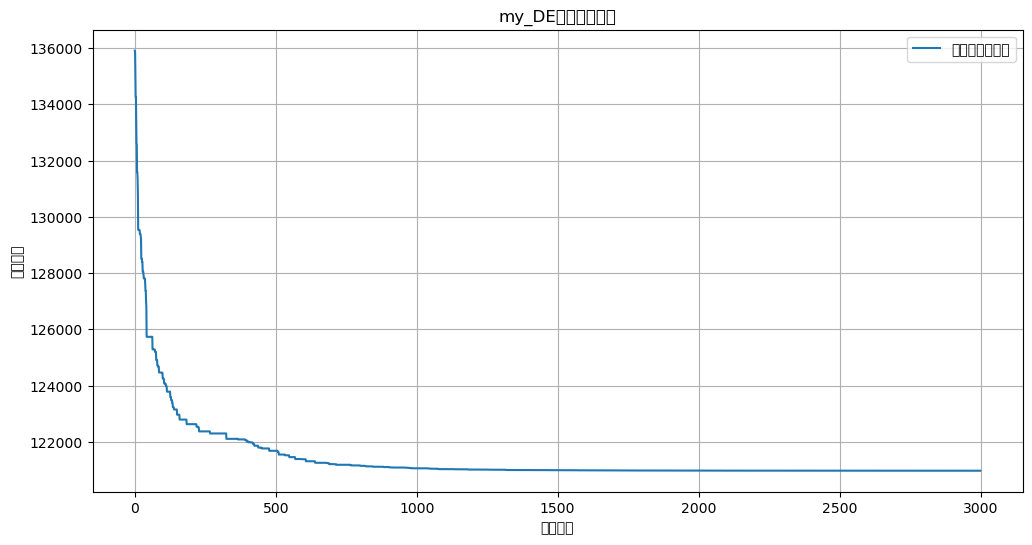

In [38]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['sans-serif']
# 使用系统已安装的中文字体，比如微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

plt.figure(figsize=(12, 6))
plt.plot(final_fitness, label='每代最佳适应度')
#plt.plot(global_best_fitness, label='全局最佳适应度')
plt.xlabel('迭代次数')
plt.ylabel('适应度值')
plt.title('my_DE算法优化过程')
plt.legend()
plt.grid(True)
plt.show()